### Import modules

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow --upgrade

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.0.0)


In [0]:
import tensorflow as tf

# Set different random seeds for comparison
tf.random.set_seed(0)
#tf.random.set_seed(2019)

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [0]:
import IPython.display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

### Input Content and Style Images

In [0]:
# Set up image path
# Use different types of content and style images
content_path1 = '/content/drive/My Drive/AML Project/people.jpg'
content_path2 = '/content/drive/My Drive/AML Project/puppy-dog.jpg'
content_path3 = '/content/drive/My Drive/AML Project/Shanghai.jpg'
content_path4 = '/content/drive/My Drive/AML Project/dancing.jpg'

style_path1   = '/content/drive/My Drive/AML Project/picasso.jpg'
style_path2   = '/content/drive/My Drive/AML Project/great_wave.jpg'
style_path3   = '/content/drive/My Drive/AML Project/Van_Gogh.jpg'
style_path4   = '/content/drive/My Drive/AML Project/cezanne.jpg'

In [0]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  img_size = max(img.size)
  scale = max_dim/img_size
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)

  img = np.expand_dims(img, axis=0)
  return img

In [0]:
def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0) 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

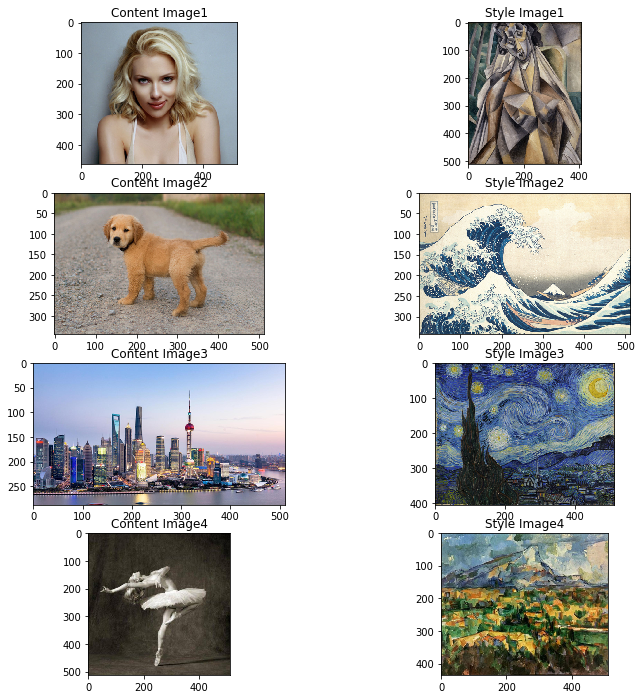

In [8]:
# Show the input content and style images
plt.figure(figsize=(12,12))

content_image1 = load_img(content_path1).astype('uint8')
style_image1 = load_img(style_path1).astype('uint8')

content_image2 = load_img(content_path2).astype('uint8')
style_image2 = load_img(style_path2).astype('uint8')

content_image3 = load_img(content_path3).astype('uint8')
style_image3 = load_img(style_path3).astype('uint8')

content_image4 = load_img(content_path4).astype('uint8')
style_image4 = load_img(style_path4).astype('uint8')

plt.subplot(4, 2, 1)
imshow(content_image1, 'Content Image1')

plt.subplot(4, 2, 2)
imshow(style_image1, 'Style Image1')

plt.subplot(4, 2, 3)
imshow(content_image2, 'Content Image2')

plt.subplot(4, 2, 4)
imshow(style_image2, 'Style Image2')

plt.subplot(4, 2, 5)
imshow(content_image3, 'Content Image3')

plt.subplot(4, 2, 6)
imshow(style_image3, 'Style Image3')

plt.subplot(4, 2, 7)
imshow(content_image4, 'Content Image4')

plt.subplot(4, 2, 8)
imshow(style_image4, 'Style Image4')
plt.show()

### Preprocess data

In [0]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  # Preprocess raw images to make it suitable to be used by pre-trained VGG19 model
  output = tf.keras.applications.vgg19.preprocess_input(img)
  return output

In [0]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                                      "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # Perform the inverse of the preprocessiing step
  # VGG networks are trained on image with each channel normalized by mean = [103.939, 116.779, 123.68] and with channels BGR
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

### Define content and style representations

In [11]:
# Use weights of pre-trained VGG19 to build our neural network
vgg = tf.keras.applications.VGG19(include_top=False, weights="/content/drive/My Drive/AML Project/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5")

for layer in vgg.layers:
  print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [0]:
# List of Content and Style layers to be considered for calculation of Content and Style Loss
# Content layer where will pull our feature maps
# Try different Content layers to see the difference
# In the reference paper, the author stated that "We therefore refer to the feature responses in higher layers of the network as the content representation."
content_layers1 = ['block5_conv2'] 
content_layers2 = ['block5_conv3']
content_layers3 = ['block4_conv2']
content_layers4 = ['block3_conv2']   

# Style layer of interest
style_layers = ['block1_conv1',
                     'block2_conv1',
                     'block3_conv1', 
                     'block4_conv1', 
                     'block5_conv1']

num_content_layers1 = len(content_layers1)
num_content_layers2 = len(content_layers2)
num_content_layers3 = len(content_layers3)
num_content_layers4 = len(content_layers4)
num_style_layers = len(style_layers)

### Build Model

In [0]:
def get_model(content_layers = content_layers1):
  """ Creates our model with access to intermediate layers."""
  # Load our model and use pre-trained VGG19 weights
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights="/content/drive/My Drive/AML Project/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5")
  vgg.trainable = False
  # Get output layers corresponding to style and content layers 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  model = tf.keras.Model([vgg.input], model_outputs)
  return model

### Define and create loss functions (both style and content loss)

#### Style Loss

In [0]:
def gram_matrix(input_tensor):
  # Since the input tensor is a 3D array of size height * width * channels, we reshape it to a 2D array of (height * width) * channels
  channels = int(input_tensor.shape[-1])
  # -1 means the size of height * width
  a = tf.reshape(input_tensor, [-1, channels])
  b = tf.reshape(input_tensor, [-1, channels])
  # Gram matrix G_ij is the inner product, and G_ij has dimension N_l * N_l
  # Thus, gram matrix is the inner product of the transpose matrix of A and A, which will have size N_l * N_l
  gram = tf.matmul(a, b, transpose_a=True)
  return gram

In [0]:
def get_style_loss(base_style, gram_target):
  # Get height, width, and num filters of each layer
  # We scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  # gram_target will be processed as a gram_matrix in the run_style_transfer step
  # Style Loss = 1/(4 * (N_l * M_l)^2) * sum_i,j((G_ij - A_ij)^2), where M_l is the height times the width of the feature map
  return tf.reduce_sum((gram_style - gram_target)**2)/(4*(channels * height * width)**2)

#### Content Loss

In [0]:
def get_content_loss(content, target):
  # Content Loss = 1/2 * sum_i,j((F_ij - P_ij)^2)
  return tf.reduce_sum((content - target)**2)/2 

#### Total Loss

In [0]:
def get_feature_representations(model, content_path, style_path):
  # Load our images
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  # Get the style and content feature representations from our model  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

In [0]:
def compute_loss(model, num_content_layers, loss_weights, init_image, gram_style_features, content_features):
  style_weight, content_weight = loss_weights

  generated = model(init_image)
  style_output_features = generated[:num_style_layers]
  content_output_features = generated[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # We use equal weights for each content and style loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer * get_content_loss(comb_content[0], target_content)

  # Get total loss
  loss = style_weight * style_score + content_weight * content_score 
  return loss, style_score, content_score

In [0]:
def compute_grads(cfg):
  # Use tf.GradientTape() to compute the gradient
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Compute gradients
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

### Style Transfer

In [0]:
def run_style_transfer(content_path, 
                                style_path,
                                content_layers=content_layers1,
                                num_iterations=1000,
                                content_weight=1, 
                                style_weight=1e3): 
  
  # Part of the function was inspired by the reference article published by TensorFlow
  display_num = 1  
  #display_num = 10
  num_content_layers = len(content_layers)

  model = get_model(content_layers) 
  for layer in model.layers:
    layer.trainable = False
  
  # Get the style and content feature representations
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Set initial content image
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create our optimizer and Adam will work here (The paper suggested L-BFGS but we saw many other referrence still used Adam and Adam also worked)
  opt = tf.keras.optimizers.Adam(learning_rate=9, beta_1=0.99, epsilon=1e-1)

  # For displaying intermediate images 
  iter_count = 1
  
  # Store our best result
  best_loss, best_img = float('inf'), None

  # Create lists to store all three losses
  content_loss = []
  style_loss = []
  total_loss = []
  
  # Create a nice config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'num_content_layers': num_content_layers,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # For displaying
  plt.figure(figsize=(12, 12))
  num_rows = (num_iterations / display_num) // 5
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means

  # Create a list to store all pictures we want in iteration process
  output = []
  iter_list = [100,200,300,400,500,600,700,800,900,1000]

  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    # grads, _ = tf.clip_by_global_norm(grads, 5.0)
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Update best loss and best image from total loss
      best_loss = loss
      best_img = init_image.numpy()

    if i % display_num == 0:
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
      start_time = time.time()

      content_loss.append(content_score)
      style_loss.append(style_score)
      total_loss.append(loss)

    if (i+1) in iter_list:
      output.append(best_img)

  print('Total time: {:.4f}s'.format(time.time() - global_start))
      
  return best_img, total_loss, style_loss, content_loss, output

### Visualization

In [0]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))
    plt.imshow(deprocess_img(best_img))
    plt.title('Output Image')
    plt.show()

### Result
#### Parameters
Content Image: Shanghai
Style Image: The Starry Night
Random Seed: 0  
Content layer: block3_conv2  
iteration: 1000  
Content Loss Weight: 1  
Style Loss Weight: 1e3  
Content-Style Loss Weight Ratio: 1:1000

Iteration: 0
Total loss: 6.2955e+12, style loss: 6.2955e+09, content loss: 0.0000e+00, time: 3.8978s
Iteration: 1
Total loss: 2.1630e+12, style loss: 2.1324e+09, content loss: 3.0632e+10, time: 3.9728s
Iteration: 2
Total loss: 2.4872e+12, style loss: 2.4260e+09, content loss: 6.1202e+10, time: 3.9835s
Iteration: 3
Total loss: 1.8947e+12, style loss: 1.8253e+09, content loss: 6.9429e+10, time: 3.9834s
Iteration: 4
Total loss: 1.6219e+12, style loss: 1.5467e+09, content loss: 7.5269e+10, time: 4.0218s
Iteration: 5
Total loss: 1.2543e+12, style loss: 1.1728e+09, content loss: 8.1492e+10, time: 4.0237s
Iteration: 6
Total loss: 1.1217e+12, style loss: 1.0339e+09, content loss: 8.7705e+10, time: 3.9792s
Iteration: 7
Total loss: 1.0310e+12, style loss: 9.3871e+08, content loss: 9.2315e+10, time: 3.9621s
Iteration: 8
Total loss: 9.4406e+11, style loss: 8.4831e+08, content loss: 9.5752e+10, time: 3.9513s
Iteration: 9
Total loss: 9.1374e+11, style loss: 8.1458e+08, content loss: 9.9159e+10, time

<Figure size 864x864 with 0 Axes>

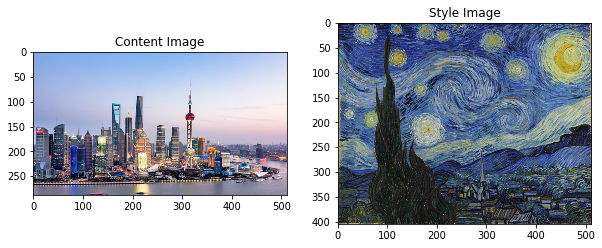

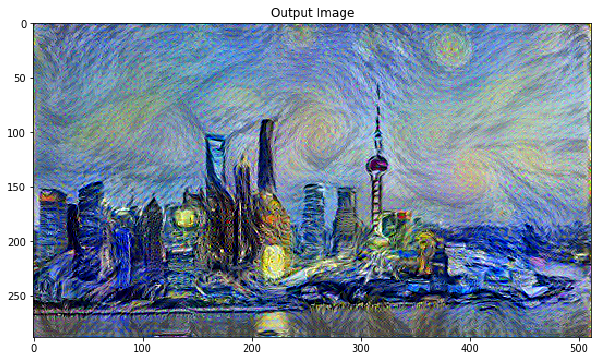

Total time: 3942.4


In [22]:
# Seed 0
import time
start = time.time()

best, best_loss, style_score, content_score, output = run_style_transfer(content_path3, style_path3, content_layers=content_layers4, num_iterations=1000, content_weight=1, style_weight = 1e3)

show_results(best, content_path3, style_path3)
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

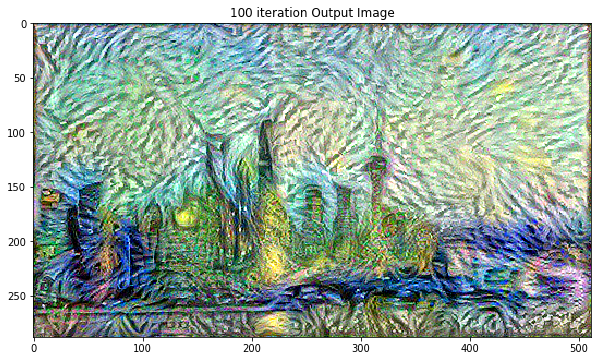

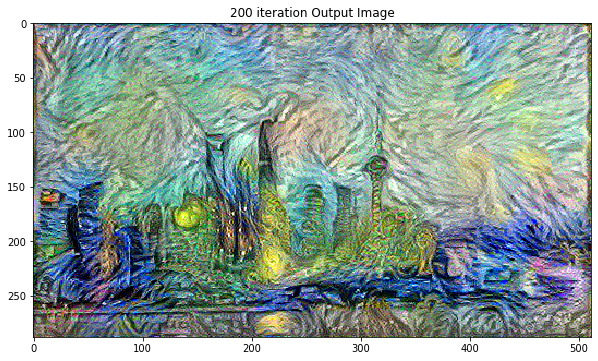

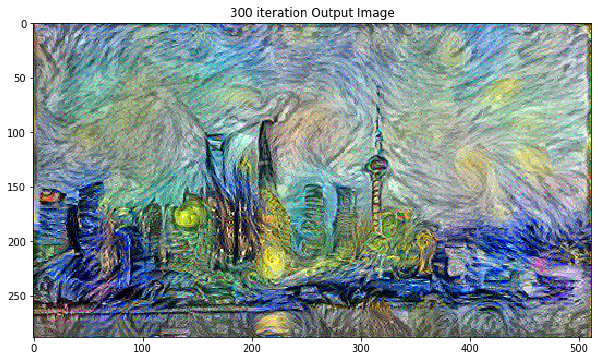

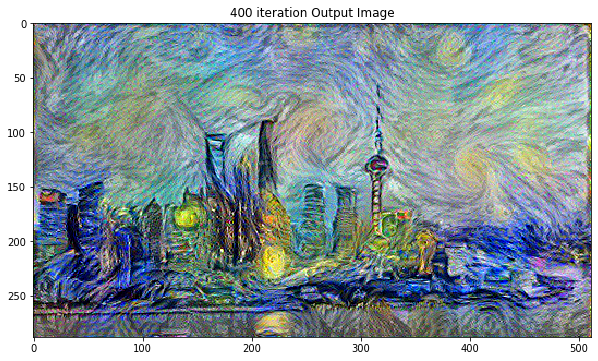

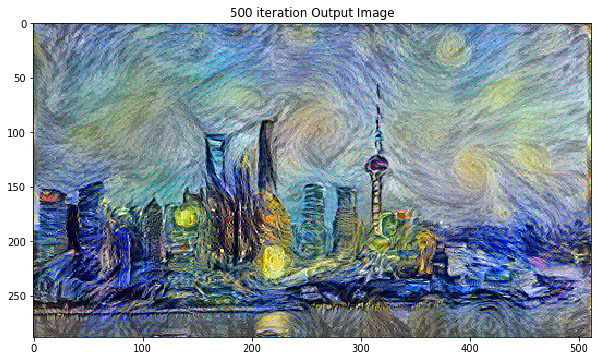

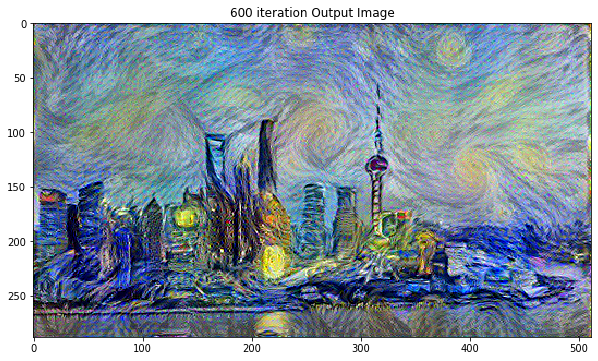

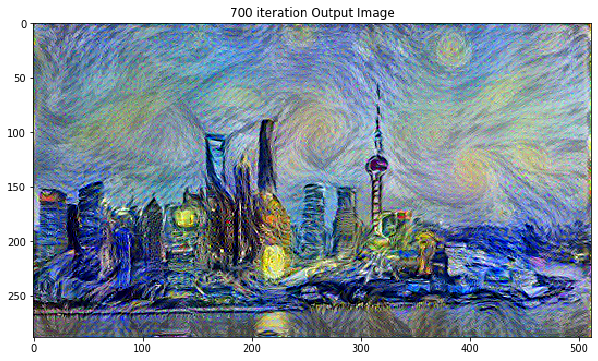

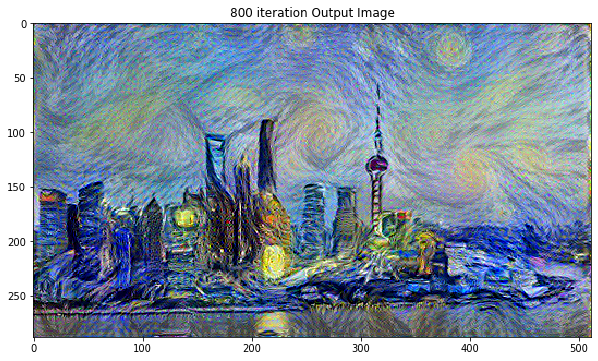

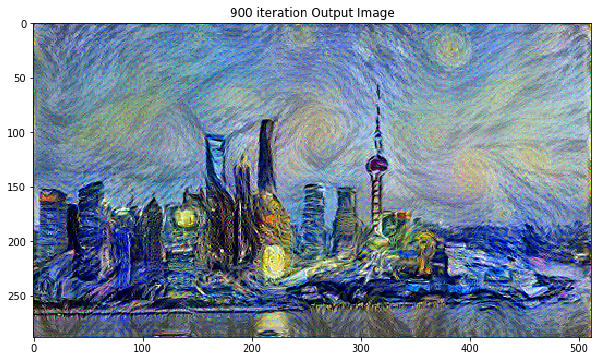

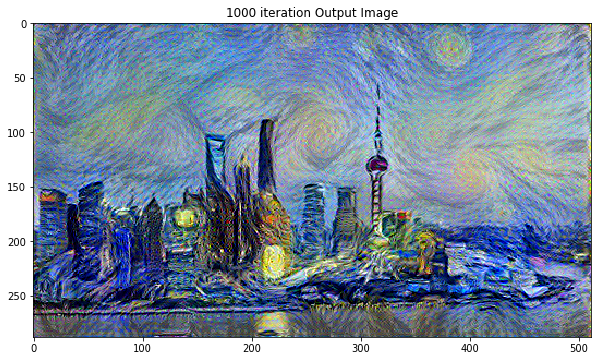

In [23]:
for i in range(len(output)):
    plt.figure(figsize=(10, 10))
    plt.imshow(deprocess_img(output[i]))
    plt.title(str((i+1)*100) + ' iteration Output Image')
    plt.show()

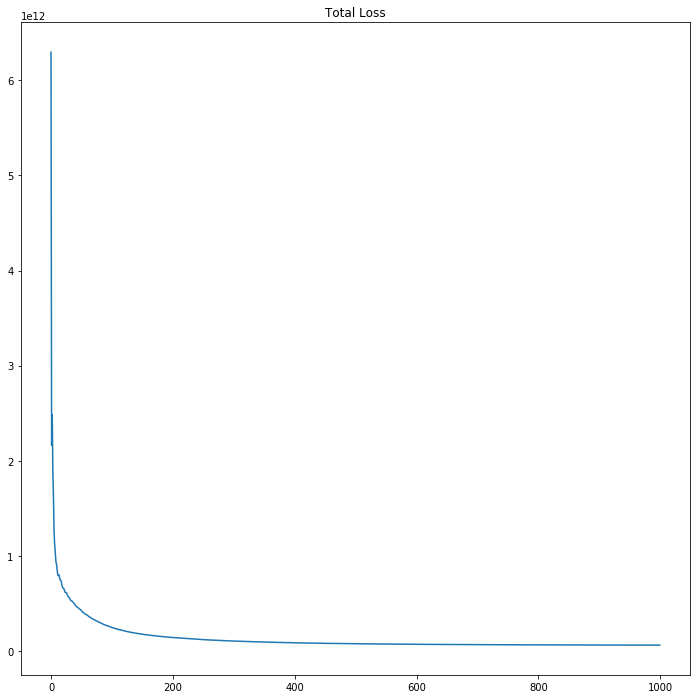

In [24]:
plt.plot(best_loss)
plt.title('Total Loss')
plt.show()

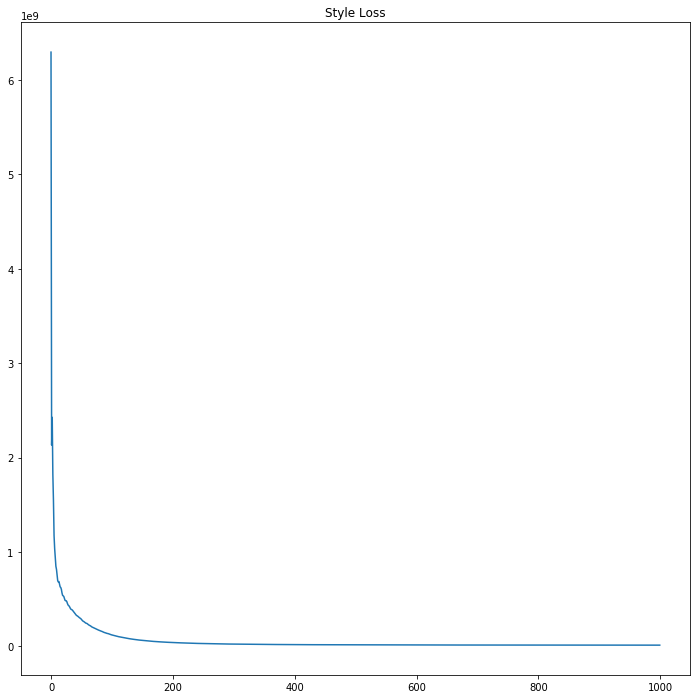

In [25]:
plt.plot(style_score)
plt.title('Style Loss')
plt.show()

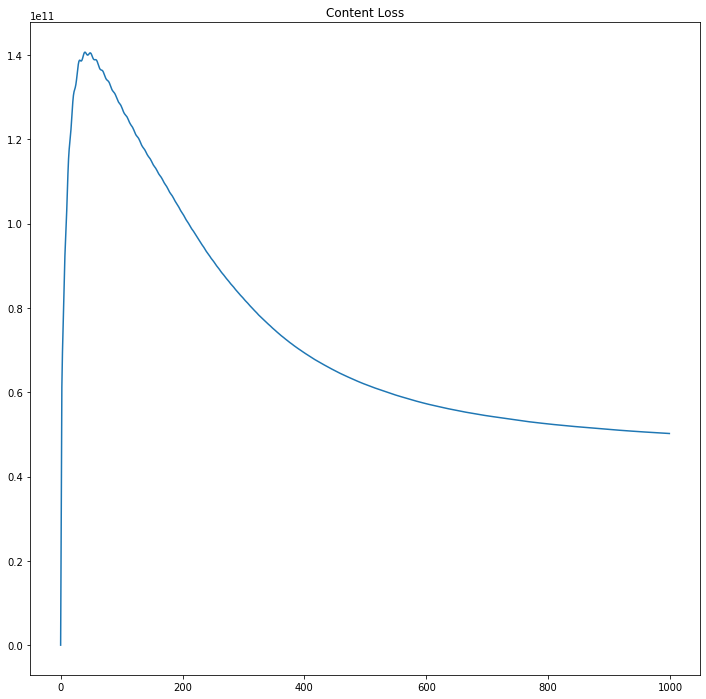

In [26]:
plt.plot(content_score)
plt.title('Content Loss')
plt.show()

By using different random seeds, content and style weight ratios, numbers of iterations and the content layers used in the model, we produced many style transferred pictures and we put many of them in our project final report.

### Reference
TensorFlow. (2018, September 27). Neural Style Transfer: Creating Art with Deep Learning using tf.keras and eager execution. Retrieved from https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398.